In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


import library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import nltk
from nltk.corpus import wordnet
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
import pickle

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
import pandas as pd

kaggle_dataset = '/content/drive/MyDrive/deeplearningProgression/kaggle_dataset.csv'
kaggle_dataset = pd.read_csv(kaggle_dataset)

huggingFace_dataset = '/content/drive/MyDrive/deeplearningProgression/huggingface_dataset.csv'
huggingFace_dataset = pd.read_csv(huggingFace_dataset)


print(kaggle_dataset.head())
print(huggingFace_dataset.head())

                                               title  \
0  law enforcement high alert following threat co...   
1                                            missing   
2  unbelievable obamas attorney general say charl...   
3  bobby jindal raised hindu us story christian c...   
4  satan 2 russia unvelis image terrifying new su...   

                                                text  label  title_missing  \
0  comment expected barack obama member fyf911 fu...      1          False   
1                          post vote hillary already      1           True   
2  demonstrator gathered last night exercising co...      1          False   
3  dozen politically active pastor came private d...      0          False   
4  rs28 sarmat missile dubbed satan 2 replace ss1...      1          False   

   text_missing                                       title_tokens  \
0         False  ['law', 'enforcement', 'high', 'alert', 'follo...   
1         False                                       

In [5]:
print(kaggle_dataset.columns)
print(huggingFace_dataset.columns)

Index(['title', 'text', 'label', 'title_missing', 'text_missing',
       'title_tokens', 'text_tokens'],
      dtype='object')
Index(['news', 'label', 'news_missing', 'label_missing', 'news_tokens'], dtype='object')


basic augumention in nlp

https://maelfabien.github.io/machinelearning/NLP_8/#synonym-replacement-sr

In [6]:
# Synonym replacement augmentation function
def synonym_replacement(text, n=1):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if len(synonyms) >= 1:
            synonym = synonyms[0].lemmas()[0].name()
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

# Random Insertion augmentation function
def random_insertion(words, n):
    words = words.split()
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    sentence = ' '.join(new_words)
    return sentence

def add_word(new_words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)

# Random Deletion augmentation function
def random_deletion(words, p):
    words = words.split()

    # If there's only one word, don't delete it
    if len(words) == 1:
        return words

    # Randomly delete words with probability p
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    # If all words are deleted, return a random word
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]

    sentence = ' '.join(new_words)
    return sentence

# Function to get synonyms for random insertion
def get_synonyms(word):
    synonyms = wordnet.synsets(word)
    return [syn.lemmas()[0].name() for syn in synonyms] if synonyms else []

# Apply data augmentation techniques (synonym replacement, random insertion, random deletion) to Kaggle dataset
kaggle_dataset['text_tokens_synonym'] = kaggle_dataset['text_tokens'].apply(lambda x: synonym_replacement(x))
kaggle_dataset['text_tokens_insertion'] = kaggle_dataset['text_tokens'].apply(lambda x: random_insertion(x, 2))  # Insert 2 random words
kaggle_dataset['text_tokens_deletion'] = kaggle_dataset['text_tokens'].apply(lambda x: random_deletion(x, 0.2))  # 20% chance of deletion

# Combine original and augmented datasets
x_train_original = kaggle_dataset['text_tokens'].values.tolist()
x_train_synonym = kaggle_dataset['text_tokens_synonym'].values.tolist()
x_train_insertion = kaggle_dataset['text_tokens_insertion'].values.tolist()
x_train_deletion = kaggle_dataset['text_tokens_deletion'].values.tolist()
y_train = kaggle_dataset['label'].values

# Concatenate original and augmented data
x_train_combined = x_train_original + x_train_synonym + x_train_insertion + x_train_deletion
y_train_combined = np.concatenate([y_train, y_train, y_train, y_train])  # Duplicate labels for augmented data


In [7]:
# Preprocessing HuggingFace dataset for testing
x_test = huggingFace_dataset['news_tokens'].values.tolist()
y_test = huggingFace_dataset['label'].values

# Display the length of the combined dataset
print(f"Length of combined dataset (original + augmented): {len(x_train_combined)}")

Length of combined dataset (original + augmented): 288536


Tokenization and padding

In [8]:
# Tokenization and padding
total_words = 10000  # Limit to top 10,000 words
tokenizer = Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(x_train_combined)  # Fit tokenizer on combined training text (original + augmented)

# Save the tokenizer for later use in Streamlit app
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Convert texts to sequences of integers
x_train_sequences = tokenizer.texts_to_sequences(x_train_combined)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

# Padding sequences to ensure uniform length
max_len_of_news = 200  # Set a fixed length for padding
x_train_padded = pad_sequences(x_train_sequences, maxlen=max_len_of_news, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_sequences, maxlen=max_len_of_news, padding='post', truncating='post')


model architecture

In [12]:
# Define the model with tuned hyperparameters and regularization
model = Sequential()
model.add(Input(shape=(max_len_of_news,)))

# Increased embedding dimensions and LSTM units
model.add(Embedding(input_dim=total_words, output_dim=128))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))  # Increased dropout for better regularization
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))

# Added L2 regularization to dense layers
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation="sigmoid"))  # Sigmoid for binary classification

# Compile the model with a lower learning rate
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 200, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 200, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 200, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,502,465 (5.73 MB)

 Trainable params: 1,502,465 (5.73 MB)

 Non-trainable params: 0 (0.00 B)

trainning

In [13]:
# Create callbacks for early stopping and model checkpoint
checkpoint = ModelCheckpoint(filepath='model_weights_epoch_{epoch:02d}.weights.h5',
                             save_weights_only=True, save_freq=5*len(x_train_combined) // 50)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with a smaller batch size
history = model.fit(x_train_padded, y_train_combined,
                    epochs=20,
                    batch_size=32,  # Decreased batch size for better generalization
                    validation_split=0.1,
                    callbacks=[checkpoint, early_stop])

Epoch 1/20
8116/8116 ━━━━━━━━━━━━━━━━━━━━ 292s 35ms/step - accuracy: 0.9356 - loss: 0.2732 - val_accuracy: 0.9729 - val_loss: 0.0963
Epoch 2/20
8116/8116 ━━━━━━━━━━━━━━━━━━━━ 311s 34ms/step - accuracy: 0.9868 - loss: 0.0585 - val_accuracy: 0.9822 - val_loss: 0.0728
Epoch 3/20
8116/8116 ━━━━━━━━━━━━━━━━━━━━ 312s 33ms/step - accuracy: 0.9941 - loss: 0.0334 - val_accuracy: 0.9827 - val_loss: 0.0728
Epoch 4/20
8116/8116 ━━━━━━━━━━━━━━━━━━━━ 322s 33ms/step - accuracy: 0.9970 - loss: 0.0218 - val_accuracy: 0.9876 - val_loss: 0.0592
Epoch 5/20
8116/8116 ━━━━━━━━━━━━━━━━━━━━ 325s 33ms/step - accuracy: 0.9978 - loss: 0.0169 - val_accuracy: 0.9872 - val_loss: 0.0668
Epoch 6/20
8116/8116 ━━━━━━━━━━━━━━━━━━━━ 321s 33ms/step - accuracy: 0.9985 - loss: 0.0150 - val_accuracy: 0.9885 - val_loss: 0.0562
Epoch 7/20
8116/8116 ━━━━━━━━━━━━━━━━━━━━ 321s 33ms/step - accuracy: 0.9989 - loss: 0.0120 - val_accuracy: 0.9843 - val_loss: 0.0967
Epoch 8/20
8116/8116 ━━━━━━━━━━━━━━━━━━━━ 322s 33ms/step - accuracy: 

save the model & evalution

In [17]:
# Save the entire model after training is complete for use in the Streamlit app
model.save('model2.h5')

# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test_padded, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

# Predict the labels for the test data
y_pred = model.predict(x_test_padded)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Print the classification report
print(classification_report(y_test, y_pred_classes, target_names=['Fake', 'Real']))

667/667 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4439 - loss: 3.5715
Test Loss: 3.846203088760376
Test Accuracy: 0.44994840025901794
667/667 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step
              precision    recall  f1-score   support

        Fake       0.51      0.61      0.56     12145
        Real       0.31      0.23      0.27      9173

    accuracy                           0.45     21318
   macro avg       0.41      0.42      0.41     21318
weighted avg       0.43      0.45      0.43     21318



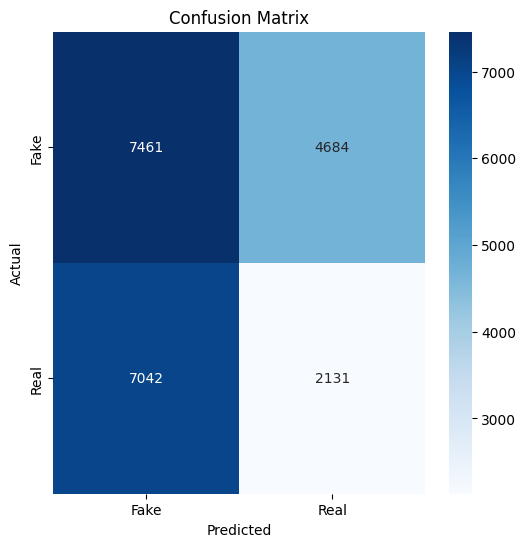

In [15]:
# Compute and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Text(0, 0.5, 'Loss')

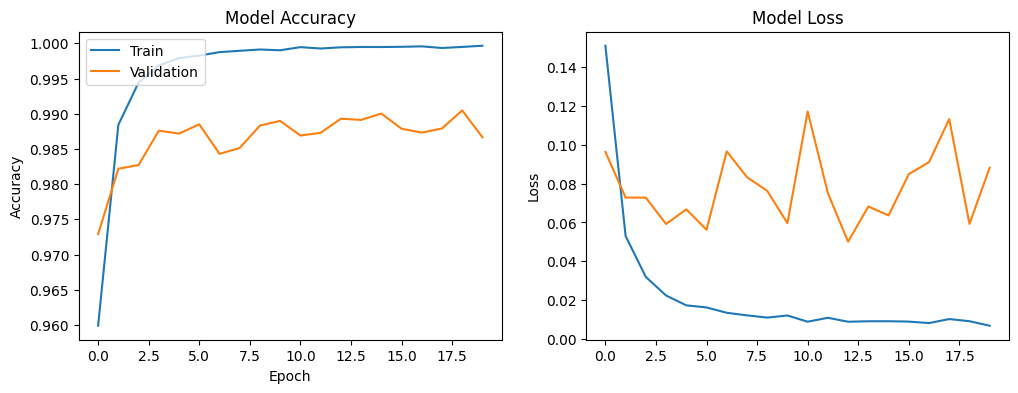

In [16]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')